### IE801 물류관리 HW2

- 이름 : 이강훈
- 학번 : 20203421

In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import copy

import gurobipy as gp
from gurobipy import GRB
from itertools import product

### Problem 1 : Generate TSP instances of n=20, 50, 100 randomly.

In [2]:
def generate_instance(num_nodes):
    x = np.random.randint(100, size=num_nodes)
    y = np.random.randint(100, size=num_nodes)
    return x, y

In [3]:
def visualize_points(x, y, title=None, tour=None):

    border = 5
    plt.xlim(0 - border, 100 + border)
    plt.ylim(0 - border, 100 + border)
    
    plt.xticks([])
    plt.yticks([])
    
    if title:
        plt.title(title)
    
    if tour is None:
        plt.scatter(x, y)
    else:
        plt.plot(x[tour], y[tour], marker='o')
        
    plt.show()
    plt.close('all')

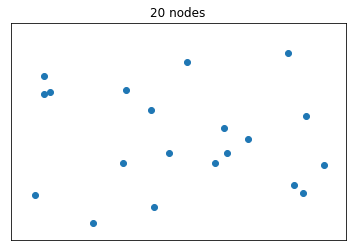

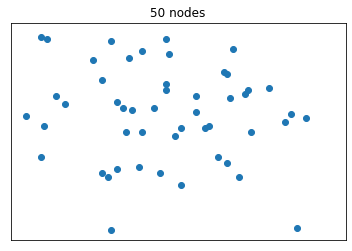

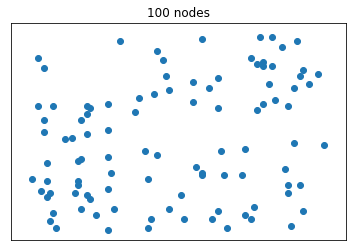

In [4]:
x, y = generate_instance(20)
visualize_points(x, y, "20 nodes")

x, y = generate_instance(50)
visualize_points(x, y, "50 nodes")

x, y = generate_instance(100)
visualize_points(x, y, "100 nodes")

### Problem 2 : Solve the problems using Gurobi and lazy constraints.

![nn](./Images/HW2_image1.png)

Reference : https://www.gurobi.com/documentation/9.1/examples/tsp_py.html

In [5]:
def get_cost(x, y):
    
    x_ = x.copy().reshape(-1, 1)
    y_ = y.copy().reshape(-1, 1)
    cost = np.sqrt((x - x_) ** 2 + (y - y_) ** 2)
    
    return cost

In [6]:
# Callback - use lazy constraints to eliminate sub-tours
def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        vals = model.cbGetSolution(model._vars)
        selected = gp.tuplelist((i, j) for i, j in model._vars.keys() if vals[i, j] > 0.5)
        # find the shortest cycle in the selected edge list
        n = int(model.ModelName)
        tour = subtour(selected, n)
        
        if len(tour) < n:
            out_nodes = list(set(range(n)) - set(tour))
            in_nodes = tour
            model.cbLazy(gp.quicksum(model._vars[i, j] for i, j in product(out_nodes, in_nodes)) >= 1)

In [7]:
# Given a tuplelist of edges, find the shortest subtour
def subtour(edges, n):
    unvisited = list(range(n))
    cycle = range(n+1)  # initial length has 1 more city
    while unvisited:  # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                         if j in unvisited]
        if len(cycle) > len(thiscycle):
            cycle = thiscycle
    return cycle

In [8]:
def solve_TSP(x, y):
    num_nodes = x.shape[0]
    cost = get_cost(x, y)
    
    model = gp.Model(name=str(num_nodes))
    model.Params.LogToConsole = 0
    variables = gp.tupledict()

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                variables[i, j] = model.addVar(obj=cost[i][j], vtype=GRB.BINARY, name=str(num_nodes))

    for i in range(num_nodes):
        temp_list = list(range(num_nodes))
        temp_list.pop(i)
        model.addConstr(sum(variables[i, j] for j in temp_list) == 1)
        model.addConstr(sum(variables[j, i] for j in temp_list) == 1)

    model._vars = variables
    model.Params.lazyConstraints = 1
    model.optimize(subtourelim)

    vals = model.getAttr('x', variables)
    selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)

    tour = subtour(selected, num_nodes)
    assert len(tour) == num_nodes
    
    tour = tour + [0]
    return tour, model.objVal

Academic license - for non-commercial use only - expires 2022-09-19
Using license file C:\Users\Kanghoon\gurobi.lic


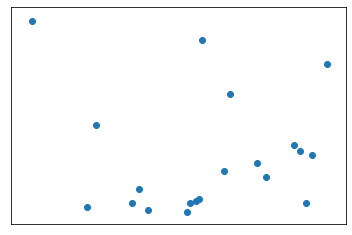

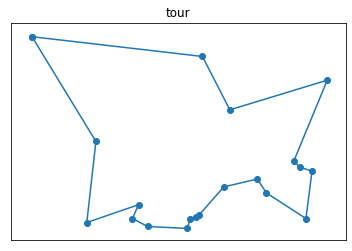

In [9]:
x, y = generate_instance(20)
tour, cost = solve_TSP(x, y)

visualize_points(x, y)
visualize_points(x, y, 'tour', tour)

### Problem 3 : Solve the problems using the Concorde and LKH solvers.